In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from random import shuffle

import time
import os

from ops import *
from utils import *

c:\users\eric\anaconda2\envs\hse_dl\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = './img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [3]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [4]:
## improved version? original seems to work fine, let's keep this in case we need it later
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    # transpose conv 1
    net = deconv2d(h_in, [BATCH_SIZE, 8, 8, 512], name="g_conv_1")
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_1")
    net = tf.nn.relu(net)
    
    # tranpose conv 2
    net = deconv2d(net, [BATCH_SIZE, 16, 16, 256], name="g_conv_2")
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_2")
    net = tf.nn.relu(net)
    
    # tranpose conv 3
    net = deconv2d(net, [BATCH_SIZE, 32, 32, 128], name="g_conv_3")
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_3")
    net = tf.nn.relu(net)
    
    # transpose conv 4
    net = deconv2d(net, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 16], name='g_conv_4')
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_4")
    net = tf.nn.relu(net)
    
    # transpose conv with stride 1 to smooth out artifacts as per Odena, et al., 2016
    h_out = tf.layers.conv2d_transpose(
            net,
            filters=N_CHANNELS,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=117932),
            name='g_conv_5'
        )

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [5]:
def discriminator(image, is_training, batch_norms=None):
    # images are cropped and resized in the get_image function rather than in the graph
    
    # conv 1 - 64x64x16
    dis = tf.layers.conv2d(
            image,
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=113),
            name='d_conv_1'
        )
    
    dis = tf.contrib.layers.batch_norm(dis, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_1")
    dis = tf.nn.leaky_relu(dis, alpha=0.2, name="lrelu_1")
    
    # max pool 1 (replaced with stride 2 conv) - 32x32x16
    dis = tf.layers.conv2d(
            dis,
            filters=16,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=113),
            name='d_pool_1'
        )
    
    # conv 2.0 - stride 1 - 32x32x32
    dis = tf.layers.conv2d(
            dis,
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=113),
            name='d_conv_2.0'
        )
    
    dis = tf.contrib.layers.batch_norm(dis, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_2.0")
    dis = tf.nn.leaky_relu(dis, alpha=0.2, name="lrelu_2.0")
    
    # conv 2.1 - stride 2 - 16x16x32
    dis = conv2d(dis, 32, name="d_conv_2.1")
    dis = tf.contrib.layers.batch_norm(dis, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_2.1")
    dis = tf.nn.leaky_relu(dis, alpha=0.2, name="lrelu_2.1")
    

    # conv 3 - stride 2 - 8x8x64
    dis = conv2d(dis, 64, name="d_conv_3")
    dis = tf.contrib.layers.batch_norm(dis, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_3")
    dis = tf.nn.leaky_relu(dis, alpha=0.2, name="lrelu_3")
    
    # conv 4 - stride 2 - 4x4x128
    dis = conv2d(dis, 128, name="d_conv_4")
    dis = tf.contrib.layers.batch_norm(dis, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_4")
    dis = tf.nn.leaky_relu(dis, alpha=0.2, name="lrelu_4")

    # flatten
    dis = tf.contrib.layers.flatten(dis)
    
    # fc 1
    dis = tf.layers.dense(
            dis,
            256,
            activation=None,
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=117),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name="d_fc1"
        )
    dis = tf.contrib.layers.batch_norm(dis, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_5")
    dis = tf.nn.relu(dis, name='fc1_relu')
    
    # get one number and apply sigmoid
    linear_out = tf.layers.dense(
            dis,
            1,
            activation=None,
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=118),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name="d_fc3"
        )
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [6]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, 64, 64, N_CHANNELS], name="images_placeholder")
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [7]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake)))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [8]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

# get the batch norm updates so we can run them
gen_extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="G")
dis_extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="D")

Load data:

In [9]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

Functions for training and evaluations.

In [10]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [11]:
# make sure the input is properly resized
idx = 0
batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]

batch[0].shape

C:\Users\eric\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\eric\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(64, 64, 3)

In [12]:
def train(sess, load_dir=None, save_frequency=50, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2, 
          print_frequency=25,
          show_samples=True,
          gen_extra_update_ops=gen_extra_update_ops, 
          dis_extra_update_ops=dis_extra_update_ops):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    # shuffle the input data
    shuffle(data)
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
            
            # Update D network
            sess.run([d_optim, dis_extra_update_ops], feed_dict={images: batch_images, z: batch_z, is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run([g_optim, gen_extra_update_ops],
                    feed_dict={z: batch_z, is_training: True})
            
            counter += 1
            # over 100,000 images means a lot of batches and we don't need to see the results for each batch
            # this will also speed up training hopefully
            if np.mod(counter, print_frequency) == 1:
                errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
                errD_real = d_loss_real.eval({images: batch_images, is_training: False})
                errG = g_loss.eval({z: batch_z, is_training: False})

                print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                    epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [8, 8],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.jpg'.format(epoch, idx)))
                print("Sample")
                
                # instead of waiting for the samples to be saved to a file let's display one right here
                if show_samples:
                    print("\n")
                    plt.imshow(inverse_transform(samples[0]))
                    plt.show()
                    print("\n\n\n")

It was difficult to train this due to the slow speed of a CPU and the low memory of my laptop GPU. The kernel crashed frequently, when this happened I restored the checkpoint and continued training.

Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint\dcgan5.model


INFO:tensorflow:Restoring parameters from checkpoint\dcgan5.model


Loaded checkpoints


C:\Users\eric\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\eric\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch: [ 0] [  24/1761] time: 484.1052, d_loss: 1.53718925, g_loss: 0.40659493
Epoch: [ 0] [  49/1761] time: 936.2093, d_loss: 1.67862391, g_loss: 0.29854181
Saved model
Epoch: [ 0] [  74/1761] time: 1364.0202, d_loss: 2.12972164, g_loss: 0.15279630
Epoch: [ 0] [  99/1761] time: 1789.8009, d_loss: 1.91841459, g_loss: 0.20627373
Saved model
Sample




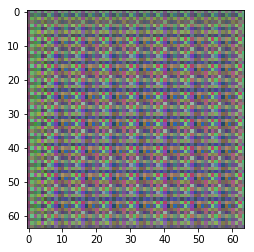





Epoch: [ 0] [ 124/1761] time: 2221.2247, d_loss: 1.87135851, g_loss: 0.24277468
Epoch: [ 0] [ 149/1761] time: 2649.1305, d_loss: 1.79414773, g_loss: 0.25847280
Saved model
Epoch: [ 0] [ 174/1761] time: 3111.0052, d_loss: 2.11931610, g_loss: 0.15966570
Epoch: [ 0] [ 199/1761] time: 3570.4363, d_loss: 1.96583176, g_loss: 0.20564869
Saved model
Sample




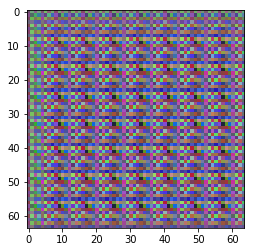





Epoch: [ 0] [ 224/1761] time: 4028.8793, d_loss: 2.52971482, g_loss: 0.09831075
Epoch: [ 0] [ 249/1761] time: 4457.4302, d_loss: 2.38448381, g_loss: 0.11289553
Saved model
Epoch: [ 0] [ 274/1761] time: 4892.6642, d_loss: 2.28818130, g_loss: 0.12574135
Epoch: [ 0] [ 299/1761] time: 5349.3509, d_loss: 2.51764870, g_loss: 0.09902561
Saved model
Sample




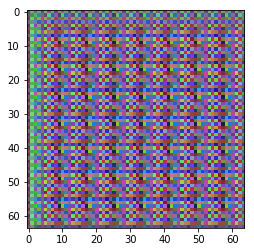





Epoch: [ 0] [ 324/1761] time: 5836.9912, d_loss: 2.41616344, g_loss: 0.10755178
Epoch: [ 0] [ 349/1761] time: 6315.0070, d_loss: 2.54728913, g_loss: 0.08766289
Saved model
Epoch: [ 0] [ 374/1761] time: 6794.4110, d_loss: 2.63073063, g_loss: 0.08383069
Epoch: [ 0] [ 399/1761] time: 7266.7504, d_loss: 2.59647417, g_loss: 0.08600014
Saved model
Sample




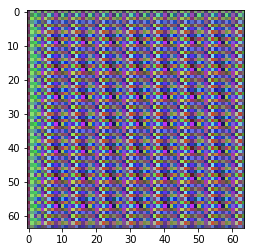





Epoch: [ 0] [ 424/1761] time: 7719.7680, d_loss: 2.23807335, g_loss: 0.12725919
Epoch: [ 0] [ 449/1761] time: 8153.3819, d_loss: 3.08952641, g_loss: 0.05001654
Saved model
Epoch: [ 0] [ 474/1761] time: 8591.1158, d_loss: 2.34436393, g_loss: 0.11306130
Epoch: [ 0] [ 499/1761] time: 9016.7967, d_loss: 2.50744414, g_loss: 0.09609479
Saved model
Sample




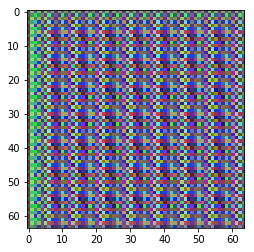





Epoch: [ 0] [ 524/1761] time: 9460.3619, d_loss: 2.21551824, g_loss: 0.13329095
Epoch: [ 0] [ 549/1761] time: 9884.1958, d_loss: 2.13311839, g_loss: 0.14101887
Saved model
Epoch: [ 0] [ 574/1761] time: 10313.7174, d_loss: 2.44516110, g_loss: 0.10164812
Epoch: [ 0] [ 599/1761] time: 10768.1695, d_loss: 2.08956909, g_loss: 0.15202163
Saved model
Sample




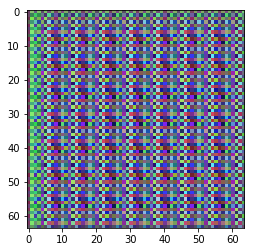

KeyboardInterrupt: 

In [19]:
# use first config to train on CPU, second on GPU
config=tf.ConfigProto(device_count={'GPU': 0})
# config = tf.ConfigProto()

with tf.Session(config=config) as sess:
    train(sess, load_dir='checkpoint', save_dir='checkpoint', show_samples=True, model_name='dcgan5.model', n_generator_update=2)

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

In [ ]:
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    
plt.imshow(inverse_transform(samples[10]))

INFO:tensorflow:Restoring parameters from checkpoint\dcgan3.model


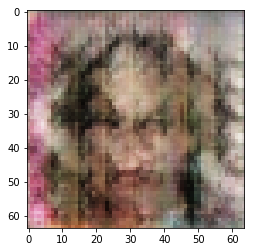

In [17]:
# this is a sample from the first run I did, it sort of looks like a face?
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    
plt.imshow(inverse_transform(samples[10]))

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [ ]:
# initialize two random vectors
z1 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)
z2 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)

# initialize a range of alphas
alphas = np.linspace(0, 1, 48)

batchz = []

# loop through and create our batch of vectors
for alpha in alphas:
    batchz.append((alpha * z1) + ((1 - alpha) * z2))
    
# convert the list into a numpy array    
batchz = np.array(batchz)

In [ ]:
# create images with our vectors as input
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batchz, is_training: False} )
    
# look at the images we created    
for image in samples:
    plt.imshow(inverse_transform(image))
    plt.show()

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

If faces looks really cool, add bonus 1 point to your score.